In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import randint
import pickle

# for clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# for dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
df_paths = pd.read_csv('images_paths.csv')
df_paths.shape

(416314, 1)

In [3]:
with open('descriptors/efficientnet-b7.pickle', 'rb') as f:
    dx = pickle.load(f)

In [17]:
with open('descriptors/efficientnet-b7.pickle', 'rb') as f:
    enb7 = pickle.load(f)
with open('descriptors/vdc_color.pickle', 'rb') as f:
    vdcc = pickle.load(f)
with open('descriptors/vdc_type.pickle', 'rb') as f:
    vdct = pickle.load(f)

In [19]:
data = np.hstack([enb7, vdcc, vdct])

In [20]:
data.shape

(416314, 3200)

In [4]:
dx.shape

(416314, 2560)

In [22]:
n_samples = 4000
idx = np.random.choice(data.shape[0], n_samples, replace=False)
dx_sample = data[idx, :]

df = df_paths.iloc[idx, :]
df.columns = ['path']

def fix_path(row):
    file = row['path'].replace('\\', '/')
    return f'raw_data/veriwild/{file}'
df['path'] = df.apply(fix_path, axis=1)


<ipython-input-22-dd4fe6067ec6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path'] = df.apply(fix_path, axis=1)


In [23]:
dx_sample.shape, df.shape

((4000, 3200), (4000, 1))

In [275]:
x = dx_sample

In [24]:
# for 3000 samples
# pca = PCA(0.8, random_state=42) # EPS=7 max clusters found
# pca = PCA(0.98, random_state=42) # EPS=9 max cluster found

pca = PCA(0.95, random_state=42)
pca.fit(dx_sample)
x = pca.transform(dx_sample)

pca.n_components_

1260

In [228]:
pca = PCA(n_components=4, random_state=42)
pca.fit(dx_sample)
x = pca.transform(dx_sample)


# x = dx_sample

In [1]:
# # for i in range(x.shape[0]):
# for i in range(1):
#     # plt.plot(np.sort(x[i]))
#     plt.plot(x[i])

In [28]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)

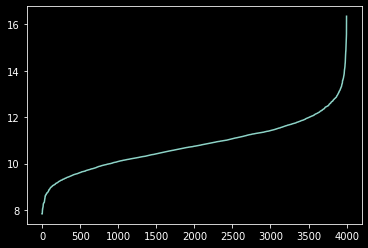

In [29]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

In [386]:
for eps in np.arange(7, 12):
# for i in range(3):
    # eps = np.random.uniform(5, 10)
    dbscan = DBSCAN(
        # eps=0.0001,
        min_samples=2,
        eps=eps,
        #  min_samples=50,
        #   metric='euclidean', algorithm ='auto'
    )
    dbscan.fit(x)
    print(f'eps={eps}', np.unique(dbscan.labels_))

eps=1 [-1]
eps=2 [-1]
eps=3 [-1]
eps=4 [-1]
eps=5 [-1]
eps=6 [-1]
eps=7 [-1]
eps=8 [-1  0  1]
eps=9 [-1  0  1  2  3]
eps=10 [-1  0  1]
eps=11 [-1  0]


In [15]:
import sklearn

AA = sklearn.metrics.pairwise.euclidean_distances(x, x)
db = DBSCAN(metric="precomputed").fit(AA)

In [33]:
dbscan = DBSCAN(
    min_samples=10,
    eps=9,
)
dbscan.fit(x)
np.unique(dbscan.labels_)

array([-1,  0,  1])

In [39]:
df.loc[:, 'label'] = dbscan.labels_

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [34]:
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(x)

KMeans(n_clusters=30, random_state=42)

In [298]:
df.loc[:, 'label'] = kmeans.labels_

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [36]:
tsne = TSNE(n_components=2, random_state=42)
projection = tsne.fit_transform(dx_sample)

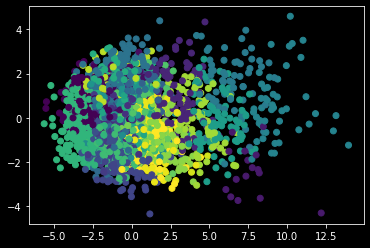

In [350]:
plt.scatter(x=x[:,0], y=x[:,1], c=kmeans.labels_)

In [42]:
# from keras.preprocessing.image import load_img 
# from keras.preprocessing.image import img_to_array 
from skimage import io

def show_cluster(df, max_images=10):
    plt.figure(figsize=(25, 25))
    # # gets the list of filenames for a cluster
    # files = groups[cluster]
    # # only allow up to LIMIT images to be shown at a time
    # if len(files) > limit:
    #     print(f"Clipping cluster size from {len(files)} to {limit}")
    #     files = files[:limit-1]
    # # plot each image in the cluster
    i = 0
    for index, row in df.iterrows():
        plt.subplot(10, 10, i+1)
        file = row['path']
        # img = load_img(file)
        img = io.imread(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        i += 1
        if i > max_images:
            break

In [40]:
clusters = df.groupby(['label']).size().to_frame(name='count').reset_index()
clusters.sort_values('count')

,label,count
2,1,10
1,0,46
0,-1,3944


In [300]:
clusters[clusters['count'] == 1].shape

(1, 2)

<AxesSubplot:xlabel='label'>

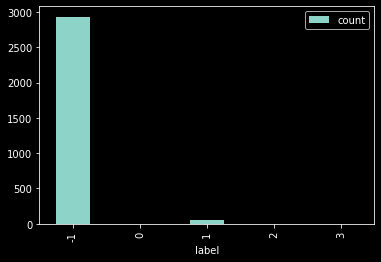

In [380]:
clusters.plot.bar(x='label', y='count')

(2, 2)

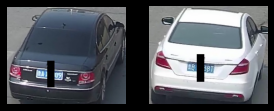

In [381]:
df_cluster = df[df['label'] == 0]
show_cluster(df_cluster, max_images=10)
df_cluster.shape